In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist
import numpy as np
from keras.initializers import RandomNormal
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization, Lambda, Cropping2D
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import cv2
import random
from matplotlib import pyplot as PLT
from matplotlib.colors import Normalize

Using TensorFlow backend.


In [2]:
xs = []
ys = []
#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0
#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * 3.14159265 / 180)

#get number of images
num_images = len(xs)
print("Numbber of images : ", num_images)

#shuffle list of images
c = list(zip(xs, ys))
random.shuffle(c)
xs, ys = zip(*c)

#train data
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

#validatioin data
val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

print("Number of Train images : ", num_train_images, "\nNumber of Test images : ", num_val_images)

Numbber of images :  45406
Number of Train images :  36324 
Number of Test images :  9081


##### Original Image

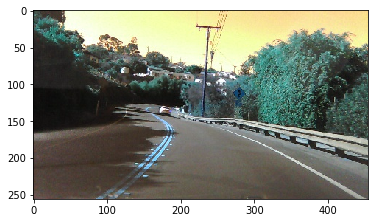

In [3]:
PLT.imshow(cv2.imread(train_xs[0]))
PLT.show()


##### Transformed Image

In [4]:
transform = lambda x : (cv2.resize(cv2.imread(x)[-150:], (200, 66)) / 255.0) - 0.5

rgb_img = transform(train_xs[0])

input_shape = rgb_img.shape
print("Transformed Image Shape : ", rgb_img.shape)

Transformed Image Shape :  (66, 200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


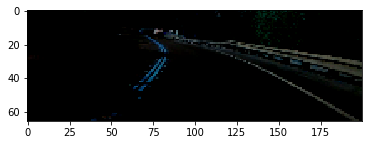

In [5]:
PLT.imshow(rgb_img)
PLT.show()

In [6]:
from tqdm import tqdm
X_train = []
for img in tqdm(train_xs):
    X_train.append(transform(img))
X_train = np.array(X_train)
X_train.shape

100%|███████████████████████████████████████████████████████████████████████████| 36324/36324 [01:54<00:00, 316.95it/s]


(36324, 66, 200, 3)

In [7]:
X_test = []
for img in tqdm(val_xs):
    X_test.append(transform(img))
X_test = np.array(X_test)
X_test.shape

100%|█████████████████████████████████████████████████████████████████████████████| 9081/9081 [00:30<00:00, 297.83it/s]


(9081, 66, 200, 3)

In [8]:
batch_size = 64
n_epochs = 10

In [9]:
MSE_loss = tf.keras.losses.MeanSquaredError()
MSE_metric = tf.keras.metrics.MeanSquaredError()
Adam_opt = tf.keras.optimizers.Adam()#epsilon=1e-03)

# Nvidia Inspired Model

# Architecture From Nvidia research paper

<img src='https://miro.medium.com/max/2400/1*2Z_8DB1ybUmRaHUsyi6bSA.png'>

# Class to build the model equvalent to Nvidia's architecture in the Image

In [10]:
class NvidiaCNN:
    
    def __init__(self, input_shape):
        self.CNN = Sequential()
        self.log = None
        
#         self.CNN.add(Lambda(transform, input_shape=input_shape))
#         self.CNN.add(Cropping2D(cropping=((70,25), (0,0))))
        
        self.CNN.add(Conv2D(24, (5, 5), strides=(2,2), input_shape = input_shape ,activation = 'elu'))
        self.CNN.add(BatchNormalization())
        self.CNN.add(Dropout(rate = .2))
        
        self.CNN.add(Conv2D(36, (5, 5), activation = 'elu', strides=(2,2)))
        
        self.CNN.add(Conv2D(48, (5, 5), activation = 'elu', strides=(2,2)))
        
        self.CNN.add(Conv2D(64, (3, 3), activation = 'elu'))
        
        self.CNN.add(Conv2D(64, (3, 3), activation = 'elu'))
        self.CNN.add(Dropout(rate = .2))
        
        self.CNN.add(Flatten())
        
        
        self.CNN.add(Dense(1164, activation = 'relu'))
        self.CNN.add(BatchNormalization())
        self.CNN.add(Dropout(rate = .2))
        
        self.CNN.add(Dense(100, activation = 'relu'))
        
        self.CNN.add(Dense(50, activation = 'relu'))
        
        self.CNN.add(Dense(10, activation = 'relu'))
        
        self.CNN.add(Dense(1))
    
    def compile_(self, loss = MSE_loss, optimizer = Adam_opt, metrics = MSE_metric):
        self.CNN.compile(loss = loss, optimizer = optimizer, metrics = [metrics])
    
    def summary(self):
        self.CNN.summary()
    
    def fit_(self, x_train, y_train, batch_size, epochs, x_test, y_test):
        self.batch_size, self.epochs = batch_size, epochs
        self.logs = self.CNN.fit(X_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_test, y_test))

    def error_plot(self):
        val_loss = self.logs.history['val_loss']
        train_loss = self.logs.history['loss']
        
        plt.plot(range(1, n_epochs+1), val_loss, 'b', label = "Validation MSE")
        plt.plot(range(1, n_epochs+1), train_loss, 'r', label = "Train MSE")
        plt.xlabel('MSE')
        plt.ylabel('Epochs')
        plt.legend()
        plt.grid()
        plt.show()
        
    def evaluate(self, X, y):
        self.CNN.evaluate(X, y, verbose=1)
        
    def predict(self, X):
        return self.CNN.predict(X, verbose=1)
    
    def results(self):
                
        return self.logs.history['loss'][self.epochs-1], self.logs.history['val_loss'][self.epochs-1]
        

In [11]:
model = NvidiaCNN(input_shape)

In [12]:
model.compile_()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 31, 98, 24)        96        
_________________________________________________________________
dropout (Dropout)            (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         3

In [14]:
model.fit_(X_train, train_ys, batch_size, n_epochs, X_test, val_ys)

Train on 36324 samples, validate on 9081 samples
Epoch 1/10
36324/36324 [==============================] - 84s 2ms/sample - loss: 0.2281 - mean_squared_error: 0.2281 - val_loss: 0.1536 - val_mean_squared_error: 0.1536
Epoch 2/10
36324/36324 [==============================] - 72s 2ms/sample - loss: 0.1856 - mean_squared_error: 0.1856 - val_loss: 0.2684 - val_mean_squared_error: 0.2684
Epoch 3/10
36324/36324 [==============================] - 57s 2ms/sample - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1535 - val_mean_squared_error: 0.1535
Epoch 4/10
36324/36324 [==============================] - 46s 1ms/sample - loss: 0.1522 - mean_squared_error: 0.1522 - val_loss: 0.1658 - val_mean_squared_error: 0.1658
Epoch 5/10
36324/36324 [==============================] - 55s 2ms/sample - loss: 0.1116 - mean_squared_error: 0.1116 - val_loss: 0.1276 - val_mean_squared_error: 0.1276
Epoch 6/10
36324/36324 [==============================] - 45s 1ms/sample - loss: 0.0796 - mean_squared_err

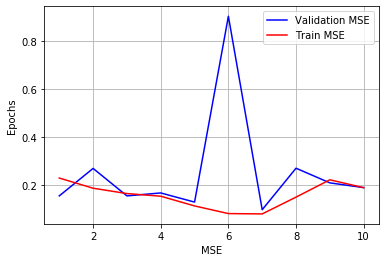

In [15]:
model.error_plot()

In [16]:
model.results()

(0.18792547306396432, 0.18810856548086582)

In [17]:
model.evaluate(X_test, val_ys)

9081/9081 [==============================] - 4s 393us/sample - loss: 0.1881 - mean_squared_error: 0.1881


In [18]:
y_pred = model.predict(X_train)

36324/36324 [==============================] - 26s 720us/sample


# Histogram of Y_Predicted and Y

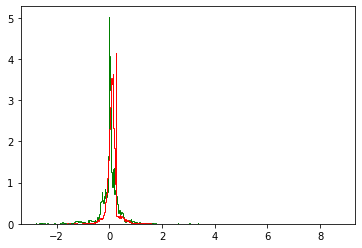

In [19]:
import numpy

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_ys, bins=500, normed=1, color='green', histtype ='step');
plt.hist(y_pred, bins=500, normed=1, color='red', histtype ='step');
plt.show()


# Testing the model

In [20]:
TX = []
Ty = []
LIMIT = 10000
CURR = 0
with open("driving_dataset/data.txt") as f:
    for line in f:
        if LIMIT <= CURR:
            break
        TX.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        Ty.append(float(line.split()[1]) * 3.14159265 / 180)
        CURR += 1

In [21]:
X_ = []
for img in tqdm(TX):
    X_.append(transform(img))
X_ = np.array(X_)
X_.shape

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 226.61it/s]


(10000, 66, 200, 3)

In [22]:
y_ = model.predict(X_)

10000/10000 [==============================] - 4s 381us/sample


#### Root Mean Squared Error

In [23]:
np.sqrt(((y_ - np.array(Ty)) ** 2).mean())

0.8827959955811951

#### Saving the output of the model

In [29]:
file_name = 'save_.pkl'

In [30]:
import pickle 
save_ = {"X" : TX, 'y' : np.array(Ty), 'y_pred' : y_}
  
with open(file_name, 'wb') as file:
    pickle.dump(save_, file)

In [31]:
if 'TX' in locals() and 'y_' in locals() and 'Ty' in locals():
    print("TX, y_, Ty in locals()")
    pass
else:

    import pickle
    with open(file_name, 'rb') as file:
        save_ = pickle.load(file)
        TX = save_['TX']
        y_ = save_['y_']
        Ty = save_['Ty']
        
    

TX, y_, Ty in locals()


##### Simulating the Predicted and Original Positions of steering wheel side by side with respect to the driving images

In [37]:
i = 0
img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape
smoothed_angle = 0
smoothed_angle_y = 0
while(cv2.waitKey(10)!= ord('q') and LIMIT > i):
    image = cv2.imread(TX[i], 0)
    cv2.imshow('Drive',image)
    
    degrees = y_[i] * 180 / 3.1415    
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * ((degrees - smoothed_angle)+0.001) / (abs(degrees - smoothed_angle)+0.001)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-int(smoothed_angle),1)
    dst = cv2.warpAffine(img,M,(cols,rows))
#     cv2.imshow("Predictied steering wheel", dst)
    
    degrees_y = Ty[i] * 180 / 3.1415    
    smoothed_angle_y += 0.2 * pow(abs((degrees_y - smoothed_angle_y)), 2.0 / 3.0) * ((degrees_y - smoothed_angle_y)+0.001) / (abs(degrees_y - smoothed_angle_y)+0.001)
    M_y = cv2.getRotationMatrix2D((cols/2,rows/2),-int(smoothed_angle_y),1)
    dst_y = cv2.warpAffine(img,M_y,(cols,rows))
#     cv2.imshow("Original steering wheel", dst_y)
    
    im_v = cv2.hconcat([dst, dst_y])
    
    print('Predicted Steering Wheel Degree :',  degrees, '| Original Steering Wheel Degree : ', degrees_y)
  

    cv2.imshow('Predicted Steering Wheel | Original Steering Wheel', im_v)
    
    i+=1
cv2.destroyAllWindows()

Predicted Steering Wheel Degree : [-2.0889418] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-2.8608732] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.2742298] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.288039] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.1230407] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.2157412] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.5081825] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-3.7537796] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-4.133114] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-4.55683] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-4.468795] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-4.930813] | 

Predicted Steering Wheel Degree : [2.7714593] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [0.6384878] | Original Steering Wheel Degree :  1.4100415841158682
Predicted Steering Wheel Degree : [1.596048] | Original Steering Wheel Degree :  1.4100415841158682
Predicted Steering Wheel Degree : [3.6292999] | Original Steering Wheel Degree :  1.4100415841158682
Predicted Steering Wheel Degree : [3.1776555] | Original Steering Wheel Degree :  1.4100415841158682
Predicted Steering Wheel Degree : [2.7521071] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [-3.457035] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-6.9297695] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-6.891212] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-7.6900587] | Original Steering Wheel Degree :  2.120062523635206
Predicted

Predicted Steering Wheel Degree : [6.4699397] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [5.0885] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [3.5978613] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [1.8281643] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [1.2376138] | Original Steering Wheel Degree :  -1.510044533343944
Predicted Steering Wheel Degree : [0.87835926] | Original Steering Wheel Degree :  -1.510044533343944
Predicted Steering Wheel Degree : [0.39476243] | Original Steering Wheel Degree :  -1.2100356856597168
Predicted Steering Wheel Degree : [-0.7197251] | Original Steering Wheel Degree :  -1.0100297872035653
Predicted Steering Wheel Degree : [-1.4739146] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [-1.4582832] | Original Steering Wheel Degree :  1

Predicted Steering Wheel Degree : [7.995387] | Original Steering Wheel Degree :  92.47272715120165
Predicted Steering Wheel Degree : [9.264094] | Original Steering Wheel Degree :  119.90353612446283
Predicted Steering Wheel Degree : [11.423675] | Original Steering Wheel Degree :  142.99421710122553
Predicted Steering Wheel Degree : [12.195668] | Original Steering Wheel Degree :  161.65476742718448
Predicted Steering Wheel Degree : [12.308694] | Original Steering Wheel Degree :  179.29528767101704
Predicted Steering Wheel Degree : [15.183899] | Original Steering Wheel Degree :  195.2357577779723
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  206.82609959350626
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  217.21640601830336
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  234.76692360783065
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  258.667628473

Predicted Steering Wheel Degree : [7.709439] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [6.7791443] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [5.8843985] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [4.7653723] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [9.715716] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [9.464054] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [13.989571] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [13.546891] | Original Steering Wheel Degree :  -2.6200772697755847
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -2.6200772697755847
Predicted Steering Wheel Degree : [15.134662] | Original Steering Wheel Degree :  -2.6200772697755847


Predicted Steering Wheel Degree : [9.324018] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [7.357916] | Original Steering Wheel Degree :  0.7100209395193379
Predicted Steering Wheel Degree : [5.6446958] | Original Steering Wheel Degree :  1.1100327364316411
Predicted Steering Wheel Degree : [4.14187] | Original Steering Wheel Degree :  1.61004748257202
Predicted Steering Wheel Degree : [2.3225498] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [1.0556582] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [0.60657966] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [0.45839605] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [0.5629642] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [2.42857] | Original Steering Wheel Degree :  2.120062523635206
Pr

Predicted Steering Wheel Degree : [-59.736942] | Original Steering Wheel Degree :  -96.30284010663696
Predicted Steering Wheel Degree : [-66.03154] | Original Steering Wheel Degree :  -97.21286694461244
Predicted Steering Wheel Degree : [-78.87714] | Original Steering Wheel Degree :  -98.22289673181601
Predicted Steering Wheel Degree : [-76.96125] | Original Steering Wheel Degree :  -99.43293241747574
Predicted Steering Wheel Degree : [-76.21917] | Original Steering Wheel Degree :  -100.54296515390737
Predicted Steering Wheel Degree : [-88.59748] | Original Steering Wheel Degree :  -101.55299494111092
Predicted Steering Wheel Degree : [-88.43302] | Original Steering Wheel Degree :  -102.1530126364794
Predicted Steering Wheel Degree : [-91.64385] | Original Steering Wheel Degree :  -102.25301558570747
Predicted Steering Wheel Degree : [-90.60084] | Original Steering Wheel Degree :  -102.25301558570747
Predicted Steering Wheel Degree : [-89.82107] | Original Steering Wheel Degree :  -102

Predicted Steering Wheel Degree : [-36.575264] | Original Steering Wheel Degree :  -57.88170701321025
Predicted Steering Wheel Degree : [-32.061775] | Original Steering Wheel Degree :  -55.26162974343466
Predicted Steering Wheel Degree : [-29.556028] | Original Steering Wheel Degree :  -51.931531534139744
Predicted Steering Wheel Degree : [-21.813929] | Original Steering Wheel Degree :  -49.92147225465542
Predicted Steering Wheel Degree : [-19.292555] | Original Steering Wheel Degree :  -46.081359004297305
Predicted Steering Wheel Degree : [-17.390253] | Original Steering Wheel Degree :  -42.661258140697115
Predicted Steering Wheel Degree : [-15.479414] | Original Steering Wheel Degree :  -39.03115108371797
Predicted Steering Wheel Degree : [-12.094291] | Original Steering Wheel Degree :  -35.09103488413179
Predicted Steering Wheel Degree : [-9.936083] | Original Steering Wheel Degree :  -29.95088329380869
Predicted Steering Wheel Degree : [-0.19606124] | Original Steering Wheel Degree

Predicted Steering Wheel Degree : [7.4683037] | Original Steering Wheel Degree :  3.8301129554353017
Predicted Steering Wheel Degree : [6.4244485] | Original Steering Wheel Degree :  3.8301129554353017
Predicted Steering Wheel Degree : [6.96083] | Original Steering Wheel Degree :  3.930115904663378
Predicted Steering Wheel Degree : [7.177021] | Original Steering Wheel Degree :  3.930115904663378
Predicted Steering Wheel Degree : [7.7159996] | Original Steering Wheel Degree :  4.030118853891453
Predicted Steering Wheel Degree : [8.14525] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [9.008606] | Original Steering Wheel Degree :  4.640136844182716
Predicted Steering Wheel Degree : [9.209552] | Original Steering Wheel Degree :  4.640136844182716
Predicted Steering Wheel Degree : [9.664664] | Original Steering Wheel Degree :  4.640136844182716
Predicted Steering Wheel Degree : [9.821588] | Original Steering Wheel Degree :  4.640136844182716
Predic

Predicted Steering Wheel Degree : [-0.76165855] | Original Steering Wheel Degree :  -25.820761490689165
Predicted Steering Wheel Degree : [-0.6094228] | Original Steering Wheel Degree :  -24.500722560878565
Predicted Steering Wheel Degree : [0.24364857] | Original Steering Wheel Degree :  -23.09068097676269
Predicted Steering Wheel Degree : [-0.213226] | Original Steering Wheel Degree :  -21.080621697278367
Predicted Steering Wheel Degree : [1.4722804] | Original Steering Wheel Degree :  -18.550547081808052
Predicted Steering Wheel Degree : [1.5551946] | Original Steering Wheel Degree :  -16.54048780232373
Predicted Steering Wheel Degree : [-0.42939252] | Original Steering Wheel Degree :  -15.230449167435939
Predicted Steering Wheel Degree : [-2.2430303] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [-2.4631124] | Original Steering Wheel Degree :  -11.190330018621678
Predicted Steering Wheel Degree : [-3.839074] | Original Steering Wheel Degr

Predicted Steering Wheel Degree : [37.715714] | Original Steering Wheel Degree :  14.320422329460449
Predicted Steering Wheel Degree : [39.30604] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [38.650806] | Original Steering Wheel Degree :  17.450514640299218
Predicted Steering Wheel Degree : [38.859623] | Original Steering Wheel Degree :  17.65052053875537
Predicted Steering Wheel Degree : [41.089424] | Original Steering Wheel Degree :  17.550517589527296
Predicted Steering Wheel Degree : [37.576275] | Original Steering Wheel Degree :  18.350541183351904
Predicted Steering Wheel Degree : [38.973705] | Original Steering Wheel Degree :  20.67060960544326
Predicted Steering Wheel Degree : [38.22775] | Original Steering Wheel Degree :  22.790672129078462
Predicted Steering Wheel Degree : [39.219944] | Original Steering Wheel Degree :  29.450868547668307
Predicted Steering Wheel Degree : [41.13971] | Original Steering Wheel Degree :  37.31110035699

Predicted Steering Wheel Degree : [238.74263] | Original Steering Wheel Degree :  216.91639717061915
Predicted Steering Wheel Degree : [242.5265] | Original Steering Wheel Degree :  218.326438754735
Predicted Steering Wheel Degree : [258.30533] | Original Steering Wheel Degree :  219.13646264348242
Predicted Steering Wheel Degree : [236.04913] | Original Steering Wheel Degree :  220.13649213576318
Predicted Steering Wheel Degree : [237.77689] | Original Steering Wheel Degree :  220.4465012783702
Predicted Steering Wheel Degree : [241.55092] | Original Steering Wheel Degree :  220.5465042275983
Predicted Steering Wheel Degree : [238.68515] | Original Steering Wheel Degree :  220.4465012783702
Predicted Steering Wheel Degree : [249.37956] | Original Steering Wheel Degree :  220.34649832914212
Predicted Steering Wheel Degree : [258.00623] | Original Steering Wheel Degree :  220.34649832914212
Predicted Steering Wheel Degree : [264.70724] | Original Steering Wheel Degree :  220.34649832914

Predicted Steering Wheel Degree : [2.975394] | Original Steering Wheel Degree :  45.18133246124463
Predicted Steering Wheel Degree : [2.737362] | Original Steering Wheel Degree :  41.14121331243037
Predicted Steering Wheel Degree : [2.1648955] | Original Steering Wheel Degree :  38.42113309342671
Predicted Steering Wheel Degree : [1.4881346] | Original Steering Wheel Degree :  37.111094458538915
Predicted Steering Wheel Degree : [1.6803795] | Original Steering Wheel Degree :  36.401073519019576
Predicted Steering Wheel Degree : [1.9576241] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [3.109783] | Original Steering Wheel Degree :  33.78099624924399
Predicted Steering Wheel Degree : [3.9009702] | Original Steering Wheel Degree :  32.57096056358427
Predicted Steering Wheel Degree : [4.181748] | Original Steering Wheel Degree :  30.860910131784177
Predicted Steering Wheel Degree : [5.3716874] | Original Steering Wheel Degree :  29.750877395352536
Predicted Stee

Predicted Steering Wheel Degree : [6.6736827] | Original Steering Wheel Degree :  13.310392542256883
Predicted Steering Wheel Degree : [6.8762403] | Original Steering Wheel Degree :  13.310392542256883
Predicted Steering Wheel Degree : [6.83654] | Original Steering Wheel Degree :  13.21038959302881
Predicted Steering Wheel Degree : [7.1566267] | Original Steering Wheel Degree :  13.010383694572656
Predicted Steering Wheel Degree : [6.7283654] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.573598] | Original Steering Wheel Degree :  12.810377796116505
Predicted Steering Wheel Degree : [6.511163] | Original Steering Wheel Degree :  12.71037484688843
Predicted Steering Wheel Degree : [6.6933637] | Original Steering Wheel Degree :  12.500368653509469
Predicted Steering Wheel Degree : [6.6705174] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.5576935] | Original Steering Wheel Degree :  11.80034800891294
Predicted Steering Wheel De

Predicted Steering Wheel Degree : [10.707098] | Original Steering Wheel Degree :  -11.80034800891294
Predicted Steering Wheel Degree : [8.999851] | Original Steering Wheel Degree :  -11.600342110456788
Predicted Steering Wheel Degree : [8.192869] | Original Steering Wheel Degree :  -11.390335917077829
Predicted Steering Wheel Degree : [7.8320174] | Original Steering Wheel Degree :  -11.390335917077829
Predicted Steering Wheel Degree : [4.5932183] | Original Steering Wheel Degree :  -11.390335917077829
Predicted Steering Wheel Degree : [3.8822942] | Original Steering Wheel Degree :  -11.390335917077829
Predicted Steering Wheel Degree : [3.4902928] | Original Steering Wheel Degree :  -10.790318221709374
Predicted Steering Wheel Degree : [1.5680023] | Original Steering Wheel Degree :  -10.290303475568994
Predicted Steering Wheel Degree : [1.2283971] | Original Steering Wheel Degree :  -9.980294332961961
Predicted Steering Wheel Degree : [0.5964741] | Original Steering Wheel Degree :  -9.8

Predicted Steering Wheel Degree : [29.321106] | Original Steering Wheel Degree :  225.08663812255293
Predicted Steering Wheel Degree : [31.970177] | Original Steering Wheel Degree :  225.08663812255293
Predicted Steering Wheel Degree : [33.273838] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [24.691948] | Original Steering Wheel Degree :  227.60671244310043
Predicted Steering Wheel Degree : [16.941887] | Original Steering Wheel Degree :  227.90672129078465
Predicted Steering Wheel Degree : [9.768114] | Original Steering Wheel Degree :  227.8067183415566
Predicted Steering Wheel Degree : [6.8220696] | Original Steering Wheel Degree :  227.09669740203722
Predicted Steering Wheel Degree : [5.7747297] | Original Steering Wheel Degree :  225.4866499194652
Predicted Steering Wheel Degree : [10.006369] | Original Steering Wheel Degree :  222.96657559891773
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  217.8264240085946
Predicted

Predicted Steering Wheel Degree : [10.057365] | Original Steering Wheel Degree :  -1.3100386348877924
Predicted Steering Wheel Degree : [10.685248] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [10.336629] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [10.386583] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [12.877267] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [15.211342] | Original Steering Wheel Degree :  

Predicted Steering Wheel Degree : [1.5767853] | Original Steering Wheel Degree :  -9.180270739137354
Predicted Steering Wheel Degree : [2.1802597] | Original Steering Wheel Degree :  -9.08026778990928
Predicted Steering Wheel Degree : [6.5583463] | Original Steering Wheel Degree :  -8.970264545758397
Predicted Steering Wheel Degree : [8.935537] | Original Steering Wheel Degree :  -8.770258647302246
Predicted Steering Wheel Degree : [14.634086] | Original Steering Wheel Degree :  -8.670255698074168
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -8.570252748846093
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -8.270243901161866
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -7.970235053477638
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  -7.060208215502149
Predicted Steering Wheel Degree : [10.704402] | Original Steering Wheel Degree :  -6.35018727

Predicted Steering Wheel Degree : [-6.0812316] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [-5.6331306] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [-5.767394] | Original Steering Wheel Degree :  1.61004748257202
Predicted Steering Wheel Degree : [-6.5195723] | Original Steering Wheel Degree :  1.61004748257202
Predicted Steering Wheel Degree : [-6.679748] | Original Steering Wheel Degree :  2.0200595744071306
Predicted Steering Wheel Degree : [-7.5192304] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-7.7843947] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-7.636667] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-6.887032] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [-6.3869157] | Original Steering Wheel Degree :  2.420071371

Predicted Steering Wheel Degree : [3.567064] | Original Steering Wheel Degree :  -0.5000147461403788
Predicted Steering Wheel Degree : [2.3364973] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [1.6524712] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-0.38758367] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-1.6380796] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [0.96371865] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-0.7690029] | Original Steering Wheel Degree :  -0.40001179691230304
Predicted Steering Wheel Degree : [-1.9525661] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [0.18283248] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [2.7528155] | Original Steering Wheel D

Predicted Steering Wheel Degree : [9.061431] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [11.152187] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [12.163527] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [13.520617] | Original Steering Wheel Degree :  -0.5000147461403788
Predicted Steering Wheel Degree : [14.669095] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.200005898456151

Predicted Steering Wheel Degree : [-2.1757236] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-1.0851202] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-0.1847023] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [1.8791771] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [3.1174526] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [4.729103] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.3525534] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.1856685] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.451584] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.2563944] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.609595] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.5979705] | Origin

Predicted Steering Wheel Degree : [7.716047] | Original Steering Wheel Degree :  0.40001179691230304
Predicted Steering Wheel Degree : [7.859352] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [7.738055] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [7.8661575] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [7.907218] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [7.749716] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [7.791574] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [7.862403] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.895001] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.835581] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7

Predicted Steering Wheel Degree : [7.6912475] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.7804956] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.873053] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.88523] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.980578] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.8961945] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.853266] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.763096] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.9232025] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [7.7166424] | Original Steering Wheel Degree :  0.3000088476842

Predicted Steering Wheel Degree : [7.7866035] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.7322803] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.7838945] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.824553] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.794273] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.921378] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8248577] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.888538] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8326583] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.907428] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.7861414] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8131933] | Original St

Predicted Steering Wheel Degree : [7.878677] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.895137] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8860264] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8519645] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.787948] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.9330745] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.939061] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8566885] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.9676466] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.980947] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.8401556] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [7.882599] | Original Ste

Predicted Steering Wheel Degree : [1.3984072] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [1.2340561] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [1.0881239] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [0.95223325] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [0.6170148] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [0.56470937] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [-0.02545516] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [-0.46044004] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [-0.36116716] | Original Steering Wheel Degree :  -1.61004748257202
Predicted Steering Wheel Degree : [-0.83132] | Original Steering Wheel Degree :  -

Predicted Steering Wheel Degree : [3.2117598] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [1.516538] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-1.39286] | Original Steering Wheel Degree :  1.8200536759509789
Predicted Steering Wheel Degree : [-1.5128496] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [-3.3039725] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [-1.5512397] | Original Steering Wheel Degree :  0.7100209395193379
Predicted Steering Wheel Degree : [-1.7689397] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [-2.2153502] | Original Steering Wheel Degree :  -1.1100327364316411
Predicted Steering Wheel Degree : [-3.010539] | Original Steering Wheel Degree :  -1.3100386348877924
Predicted Steering Wheel Degree : [-3.3460224] | Original Steering Wheel Degree :  -1.31003863488779

Predicted Steering Wheel Degree : [-1.1975212] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-0.6515253] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-0.07138442] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [-0.44731376] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [-1.6959502] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [-1.7966917] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [-2.4268105] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [0.12421919] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [1.129248] | Original Steering Wheel Degree :  -0.10000294922807576
Predicted Steering Wheel Degree : [2.2656994] | Original Steering W

Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.40001179691230304
Predicted Steering Wheel Degree : [12.800108] | Original Steering Wheel Degree :  0.6100179902912621
Predicted Steering Wheel Degree : [11.239632] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [11.733019] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [14.876527] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  1.31003

Predicted Steering Wheel Degree : [-5.762157] | Original Steering Wheel Degree :  -8.570252748846093
Predicted Steering Wheel Degree : [-5.670777] | Original Steering Wheel Degree :  -8.370246850389941
Predicted Steering Wheel Degree : [-5.780619] | Original Steering Wheel Degree :  -7.970235053477638
Predicted Steering Wheel Degree : [-8.326769] | Original Steering Wheel Degree :  -7.360217063186377
Predicted Steering Wheel Degree : [-7.8731966] | Original Steering Wheel Degree :  -7.060208215502149
Predicted Steering Wheel Degree : [-7.1760545] | Original Steering Wheel Degree :  -6.860202317045998
Predicted Steering Wheel Degree : [-5.1587396] | Original Steering Wheel Degree :  -6.860202317045998
Predicted Steering Wheel Degree : [-4.8263044] | Original Steering Wheel Degree :  -6.860202317045998
Predicted Steering Wheel Degree : [-12.895088] | Original Steering Wheel Degree :  -6.860202317045998
Predicted Steering Wheel Degree : [-12.667253] | Original Steering Wheel Degree :  -6.

Predicted Steering Wheel Degree : [-1.6867906] | Original Steering Wheel Degree :  -10.790318221709374
Predicted Steering Wheel Degree : [-1.9201595] | Original Steering Wheel Degree :  -10.89032117093745
Predicted Steering Wheel Degree : [-1.5550256] | Original Steering Wheel Degree :  -10.89032117093745
Predicted Steering Wheel Degree : [-1.6225405] | Original Steering Wheel Degree :  -10.89032117093745
Predicted Steering Wheel Degree : [-1.9978842] | Original Steering Wheel Degree :  -10.990324120165527
Predicted Steering Wheel Degree : [-2.5107388] | Original Steering Wheel Degree :  -11.090327069393602
Predicted Steering Wheel Degree : [-2.7931893] | Original Steering Wheel Degree :  -11.190330018621678
Predicted Steering Wheel Degree : [-3.8152974] | Original Steering Wheel Degree :  -11.190330018621678
Predicted Steering Wheel Degree : [-3.903355] | Original Steering Wheel Degree :  -11.190330018621678
Predicted Steering Wheel Degree : [-3.5802057] | Original Steering Wheel Degr

Predicted Steering Wheel Degree : [5.575746] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [4.8020916] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [5.6619344] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [5.3822665] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [6.77713] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [4.561116] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [5.356651] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [0.47960612] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [2.6824183] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [3.9813654] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [

Predicted Steering Wheel Degree : [5.483324] | Original Steering Wheel Degree :  -2.9200861174598125
Predicted Steering Wheel Degree : [5.3563585] | Original Steering Wheel Degree :  -3.030089361610695
Predicted Steering Wheel Degree : [5.1748815] | Original Steering Wheel Degree :  -3.130092310838771
Predicted Steering Wheel Degree : [5.1477714] | Original Steering Wheel Degree :  -3.230095260066847
Predicted Steering Wheel Degree : [5.175353] | Original Steering Wheel Degree :  -3.330098209294923
Predicted Steering Wheel Degree : [4.9155393] | Original Steering Wheel Degree :  -3.330098209294923
Predicted Steering Wheel Degree : [4.5496106] | Original Steering Wheel Degree :  -3.330098209294923
Predicted Steering Wheel Degree : [4.278558] | Original Steering Wheel Degree :  -3.130092310838771
Predicted Steering Wheel Degree : [4.007928] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [3.6348984] | Original Steering Wheel Degree :  -1.510044533

Predicted Steering Wheel Degree : [-1.0536184] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [-1.8024684] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [-1.5605035] | Original Steering Wheel Degree :  1.8200536759509789
Predicted Steering Wheel Degree : [-1.1188811] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-1.1665317] | Original Steering Wheel Degree :  2.520074320547509
Predicted Steering Wheel Degree : [-0.5628891] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [-0.8026085] | Original Steering Wheel Degree :  3.130092310838771
Predicted Steering Wheel Degree : [-0.42850798] | Original Steering Wheel Degree :  3.430101158522999
Predicted Steering Wheel Degree : [-0.5292921] | Original Steering Wheel Degree :  3.930115904663378
Predicted Steering Wheel Degree : [-0.7039708] | Original Steering Wheel Degree :  4.44

Predicted Steering Wheel Degree : [10.459922] | Original Steering Wheel Degree :  6.860202317045998
Predicted Steering Wheel Degree : [10.297051] | Original Steering Wheel Degree :  6.860202317045998
Predicted Steering Wheel Degree : [10.249186] | Original Steering Wheel Degree :  6.4501902252108865
Predicted Steering Wheel Degree : [10.4520645] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [10.589656] | Original Steering Wheel Degree :  5.450160732930129
Predicted Steering Wheel Degree : [10.178307] | Original Steering Wheel Degree :  5.340157488779246
Predicted Steering Wheel Degree : [10.040895] | Original Steering Wheel Degree :  5.140151590323094
Predicted Steering Wheel Degree : [10.323716] | Original Steering Wheel Degree :  4.840142742638867
Predicted Steering Wheel Degree : [10.576664] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [10.527693] | Original Steering Wheel Degree :  4.740139793410791
Predicted St

Predicted Steering Wheel Degree : [7.617182] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.6675324] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.373525] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.2984047] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.3672757] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.3616085] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.181682] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [7.1844387] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [6.984888] | Original Steering Wheel Degree :  4.4401309457265645
Predicted Steering Wheel Degree : [6.7786016] | Original Steering Wheel Degree :  4.44013094572

Predicted Steering Wheel Degree : [8.871137] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [9.008442] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.89992] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.891645] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.746423] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.979396] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.942602] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [8.8558655] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [9.063322] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [9.282234] | Original Steering Wheel Degree :  2.4200713713194335


Predicted Steering Wheel Degree : [7.367871] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.4288635] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.364687] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.2811127] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.3608975] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.3382797] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.4662495] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.4429145] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.370546] | Original Steering Wheel Degree :  2.4200713713194335
Predicted Steering Wheel Degree : [7.3279643] | Original Steering Wheel Degree :  2.4200713713

Predicted Steering Wheel Degree : [7.307995] | Original Steering Wheel Degree :  2.9200861174598125
Predicted Steering Wheel Degree : [7.1750503] | Original Steering Wheel Degree :  2.9200861174598125
Predicted Steering Wheel Degree : [7.241897] | Original Steering Wheel Degree :  3.130092310838771
Predicted Steering Wheel Degree : [7.1157293] | Original Steering Wheel Degree :  3.330098209294923
Predicted Steering Wheel Degree : [7.2657266] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.15855] | Original Steering Wheel Degree :  2.6200772697755847
Predicted Steering Wheel Degree : [7.0998545] | Original Steering Wheel Degree :  2.6200772697755847
Predicted Steering Wheel Degree : [7.2998714] | Original Steering Wheel Degree :  2.6200772697755847
Predicted Steering Wheel Degree : [7.190665] | Original Steering Wheel Degree :  2.6200772697755847
Predicted Steering Wheel Degree : [7.1788116] | Original Steering Wheel Degree :  2.62007726977558

Predicted Steering Wheel Degree : [-2.4868922] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [-2.1924582] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [-1.5782677] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [-0.6220881] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-0.46003193] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [-0.44642237] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [-0.10060312] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [0.28009212] | Original Steering Wheel Degree :  0.40001179691230304
Predicted Steering Wheel Degree : [1.7022998] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [2.0604172] | Original Steering Wheel Degree :  0.5000

Predicted Steering Wheel Degree : [6.8099737] | Original Steering Wheel Degree :  3.030089361610695
Predicted Steering Wheel Degree : [6.8569] | Original Steering Wheel Degree :  3.230095260066847
Predicted Steering Wheel Degree : [6.81778] | Original Steering Wheel Degree :  3.330098209294923
Predicted Steering Wheel Degree : [6.822423] | Original Steering Wheel Degree :  3.330098209294923
Predicted Steering Wheel Degree : [6.8587694] | Original Steering Wheel Degree :  3.330098209294923
Predicted Steering Wheel Degree : [6.897726] | Original Steering Wheel Degree :  3.430101158522999
Predicted Steering Wheel Degree : [6.9409547] | Original Steering Wheel Degree :  3.330098209294923
Predicted Steering Wheel Degree : [6.728493] | Original Steering Wheel Degree :  3.430101158522999
Predicted Steering Wheel Degree : [6.9692426] | Original Steering Wheel Degree :  3.430101158522999
Predicted Steering Wheel Degree : [6.858466] | Original Steering Wheel Degree :  3.430101158522999
Predicted

Predicted Steering Wheel Degree : [7.1240277] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [6.9570055] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [6.9791803] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.1956816] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.043999] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.0650706] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.0526323] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.205952] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.0729976] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [7.0351214] | Original Steering Wheel Degree :  2.220065472

Predicted Steering Wheel Degree : [7.6753755] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.5486465] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.5699544] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.4375825] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.5254307] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.516136] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [7.348785] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [7.32094] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [7.4871573] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [7.4076715] | Original Steering Wheel Degree :  2.72008021900366

Predicted Steering Wheel Degree : [3.7928562] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [3.4598463] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [3.1760883] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [2.8715696] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [3.0599551] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [2.8884323] | Original Steering Wheel Degree :  1.8200536759509789
Predicted Steering Wheel Degree : [3.1962478] | Original Steering Wheel Degree :  1.8200536759509789
Predicted Steering Wheel Degree : [2.999893] | Original Steering Wheel Degree :  2.0200595744071306
Predicted Steering Wheel Degree : [2.843103] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [2.5643778] | Original Steering Wheel Degree :  2.2200654728632823
Predicte

Predicted Steering Wheel Degree : [1.5088503] | Original Steering Wheel Degree :  8.270243901161866
Predicted Steering Wheel Degree : [0.9032406] | Original Steering Wheel Degree :  8.270243901161866
Predicted Steering Wheel Degree : [2.598665] | Original Steering Wheel Degree :  8.270243901161866
Predicted Steering Wheel Degree : [4.2350554] | Original Steering Wheel Degree :  8.270243901161866
Predicted Steering Wheel Degree : [4.519863] | Original Steering Wheel Degree :  7.970235053477638
Predicted Steering Wheel Degree : [5.938146] | Original Steering Wheel Degree :  7.560222961642528
Predicted Steering Wheel Degree : [6.5154133] | Original Steering Wheel Degree :  7.060208215502149
Predicted Steering Wheel Degree : [6.714039] | Original Steering Wheel Degree :  6.4501902252108865
Predicted Steering Wheel Degree : [6.92041] | Original Steering Wheel Degree :  5.850172529842432
Predicted Steering Wheel Degree : [7.2281756] | Original Steering Wheel Degree :  5.2401545395511695
Pred

Predicted Steering Wheel Degree : [11.520608] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [13.087189] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [13.801798] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [14.241697] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [14.4630785] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [15.229664] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [14.625096] | Original Steering Wheel Degree :  15.130446218207863
Predicted Steering Wheel Degree : [12.82264] | Original Steering Wheel Degree :  15.030443268979786
Predicted Steering Wheel Degree : [7.6012836] | Original Steering Wheel Degree :  14.920440024828903
Predicted Steering Wheel Degree : [3.8405323] | Original Steering Wheel Degree :  14.720434

Predicted Steering Wheel Degree : [0.01844376] | Original Steering Wheel Degree :  14.220419380232373
Predicted Steering Wheel Degree : [-0.18812092] | Original Steering Wheel Degree :  12.910380745344582
Predicted Steering Wheel Degree : [-0.036838] | Original Steering Wheel Degree :  12.000353907369092
Predicted Steering Wheel Degree : [1.0584843] | Original Steering Wheel Degree :  11.700345059684864
Predicted Steering Wheel Degree : [1.404633] | Original Steering Wheel Degree :  11.500339161228712
Predicted Steering Wheel Degree : [2.034648] | Original Steering Wheel Degree :  11.500339161228712
Predicted Steering Wheel Degree : [3.2764316] | Original Steering Wheel Degree :  11.390335917077829
Predicted Steering Wheel Degree : [4.955234] | Original Steering Wheel Degree :  11.290332967849752
Predicted Steering Wheel Degree : [5.123811] | Original Steering Wheel Degree :  11.190330018621678
Predicted Steering Wheel Degree : [6.094617] | Original Steering Wheel Degree :  11.19033001

Predicted Steering Wheel Degree : [7.0854015] | Original Steering Wheel Degree :  6.050178428298583
Predicted Steering Wheel Degree : [8.047446] | Original Steering Wheel Degree :  5.140151590323094
Predicted Steering Wheel Degree : [6.6590524] | Original Steering Wheel Degree :  4.640136844182716
Predicted Steering Wheel Degree : [7.3505554] | Original Steering Wheel Degree :  4.340127996498488
Predicted Steering Wheel Degree : [4.7270412] | Original Steering Wheel Degree :  4.240125047270412
Predicted Steering Wheel Degree : [3.9688456] | Original Steering Wheel Degree :  4.030118853891453
Predicted Steering Wheel Degree : [2.6653678] | Original Steering Wheel Degree :  3.430101158522999
Predicted Steering Wheel Degree : [2.088837] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [2.0259194] | Original Steering Wheel Degree :  1.7100504318000955
Predicted Steering Wheel Degree : [3.129311] | Original Steering Wheel Degree :  0.7100209395193379
P

Predicted Steering Wheel Degree : [8.733056] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [9.535919] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [9.380993] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [10.507811] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [11.148182] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [11.110623] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [10.793039] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [10.576487] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [10.359077] | Original Steering Wheel Degree :  -2.120062523635206
Predicted Steering Wheel Degree : [10.795326] | Original Steering Wheel Degree :  -1.7200507

Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.740139793410791
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  4.9401456918669435
Predicted Ste

Predicted Steering Wheel Degree : [153.18085] | Original Steering Wheel Degree :  234.66692065860258
Predicted Steering Wheel Degree : [165.13376] | Original Steering Wheel Degree :  236.4769740396307
Predicted Steering Wheel Degree : [239.60556] | Original Steering Wheel Degree :  238.18702447143085
Predicted Steering Wheel Degree : [238.66615] | Original Steering Wheel Degree :  240.81710203612926
Predicted Steering Wheel Degree : [213.0589] | Original Steering Wheel Degree :  244.44720909310843
Predicted Steering Wheel Degree : [162.55836] | Original Steering Wheel Degree :  246.66727456597164
Predicted Steering Wheel Degree : [140.5552] | Original Steering Wheel Degree :  249.78736658188765
Predicted Steering Wheel Degree : [102.7468] | Original Steering Wheel Degree :  252.9174588927264
Predicted Steering Wheel Degree : [99.826675] | Original Steering Wheel Degree :  254.5275063752985
Predicted Steering Wheel Degree : [89.33285] | Original Steering Wheel Degree :  255.037521416361

Predicted Steering Wheel Degree : [20.216005] | Original Steering Wheel Degree :  28.440838760464747
Predicted Steering Wheel Degree : [20.610682] | Original Steering Wheel Degree :  27.53081192248926
Predicted Steering Wheel Degree : [20.479382] | Original Steering Wheel Degree :  26.720788033741844
Predicted Steering Wheel Degree : [19.256035] | Original Steering Wheel Degree :  25.92076443991724
Predicted Steering Wheel Degree : [15.91325] | Original Steering Wheel Degree :  25.41074939885405
Predicted Steering Wheel Degree : [13.412285] | Original Steering Wheel Degree :  24.200713713194332
Predicted Steering Wheel Degree : [8.65537] | Original Steering Wheel Degree :  22.990678027534617
Predicted Steering Wheel Degree : [7.5678525] | Original Steering Wheel Degree :  21.980648240331053
Predicted Steering Wheel Degree : [6.32248] | Original Steering Wheel Degree :  21.7806423418749
Predicted Steering Wheel Degree : [5.657191] | Original Steering Wheel Degree :  21.380630544962596
P

Predicted Steering Wheel Degree : [7.9461513] | Original Steering Wheel Degree :  10.690315272481298
Predicted Steering Wheel Degree : [7.446187] | Original Steering Wheel Degree :  10.180300231418112
Predicted Steering Wheel Degree : [6.92569] | Original Steering Wheel Degree :  9.680285485277734
Predicted Steering Wheel Degree : [7.5316296] | Original Steering Wheel Degree :  8.87026159653032
Predicted Steering Wheel Degree : [6.838204] | Original Steering Wheel Degree :  8.070238002705715
Predicted Steering Wheel Degree : [7.0208383] | Original Steering Wheel Degree :  7.460220012414451
Predicted Steering Wheel Degree : [7.206774] | Original Steering Wheel Degree :  6.960205266274073
Predicted Steering Wheel Degree : [7.224033] | Original Steering Wheel Degree :  6.660196418589846
Predicted Steering Wheel Degree : [7.9356503] | Original Steering Wheel Degree :  6.550193174438963
Predicted Steering Wheel Degree : [8.083458] | Original Steering Wheel Degree :  6.350187275982811
Predic

Predicted Steering Wheel Degree : [4.285752] | Original Steering Wheel Degree :  8.17024095193379
Predicted Steering Wheel Degree : [5.198211] | Original Steering Wheel Degree :  7.6602259108706034
Predicted Steering Wheel Degree : [7.6052346] | Original Steering Wheel Degree :  7.1602111647302245
Predicted Steering Wheel Degree : [8.987897] | Original Steering Wheel Degree :  6.760199367817921
Predicted Steering Wheel Degree : [10.162499] | Original Steering Wheel Degree :  6.250184326754734
Predicted Steering Wheel Degree : [10.455052] | Original Steering Wheel Degree :  5.550163682158204
Predicted Steering Wheel Degree : [9.269978] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [8.207645] | Original Steering Wheel Degree :  4.240125047270412
Predicted Steering Wheel Degree : [6.3351407] | Original Steering Wheel Degree :  3.7301100062072257
Predicted Steering Wheel Degree : [6.4383354] | Original Steering Wheel Degree :  3.130092310838771
Predicted Steerin

Predicted Steering Wheel Degree : [2.8392568] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [2.8082912] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [3.8619533] | Original Steering Wheel Degree :  0.7100209395193379
Predicted Steering Wheel Degree : [4.0818424] | Original Steering Wheel Degree :  0.3000088476842273
Predicted Steering Wheel Degree : [4.862602] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [5.5586476] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [5.9270177] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [5.427386] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [5.4639387] | Original Steering Wheel Degree :  -0.5000147461403788
Predicted Steering Wheel Degree : [5.800372] | Original Steering Wheel Degree :  0.0
Pred

Predicted Steering Wheel Degree : [5.891285] | Original Steering Wheel Degree :  14.220419380232373
Predicted Steering Wheel Degree : [5.793695] | Original Steering Wheel Degree :  14.720434126372753
Predicted Steering Wheel Degree : [6.453288] | Original Steering Wheel Degree :  14.920440024828903
Predicted Steering Wheel Degree : [6.351226] | Original Steering Wheel Degree :  15.230449167435939
Predicted Steering Wheel Degree : [4.993691] | Original Steering Wheel Degree :  15.630460964348242
Predicted Steering Wheel Degree : [4.439565] | Original Steering Wheel Degree :  16.34048190386758
Predicted Steering Wheel Degree : [2.4195259] | Original Steering Wheel Degree :  16.84049665000796
Predicted Steering Wheel Degree : [2.310531] | Original Steering Wheel Degree :  17.65052053875537
Predicted Steering Wheel Degree : [2.1432595] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [2.4125435] | Original Steering Wheel Degree :  18.760553275187014
P

Predicted Steering Wheel Degree : [20.888578] | Original Steering Wheel Degree :  15.730463913576315
Predicted Steering Wheel Degree : [20.513508] | Original Steering Wheel Degree :  15.930469812032468
Predicted Steering Wheel Degree : [21.899109] | Original Steering Wheel Degree :  16.34048190386758
Predicted Steering Wheel Degree : [22.24273] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [23.168005] | Original Steering Wheel Degree :  16.640490751551805
Predicted Steering Wheel Degree : [23.745932] | Original Steering Wheel Degree :  16.740493700779883
Predicted Steering Wheel Degree : [23.338438] | Original Steering Wheel Degree :  16.740493700779883
Predicted Steering Wheel Degree : [24.767824] | Original Steering Wheel Degree :  16.740493700779883
Predicted Steering Wheel Degree : [25.944351] | Original Steering Wheel Degree :  17.040502548464108
Predicted Steering Wheel Degree : [25.934843] | Original Steering Wheel Degree :  17.45051464

Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  12.910380745344582
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.110386643800732
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.21038959302881
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.21038959302881
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.310392542256883
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.610401389941112
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  13.920410532548146
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  14.320422329460449
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  14.420425278688526
Predict

Predicted Steering Wheel Degree : [4.088074] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [4.6385474] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [4.241314] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [4.745699] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [5.4663053] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.1351433] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.1548085] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [5.3729243] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [5.6847653] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [7.329158] | Original Steering Wheel Degree :  1.31003863488

Predicted Steering Wheel Degree : [6.508049] | Original Steering Wheel Degree :  -14.420425278688526
Predicted Steering Wheel Degree : [5.342946] | Original Steering Wheel Degree :  -14.820437075600827
Predicted Steering Wheel Degree : [4.1961207] | Original Steering Wheel Degree :  -15.130446218207863
Predicted Steering Wheel Degree : [4.34441] | Original Steering Wheel Degree :  -15.230449167435939
Predicted Steering Wheel Degree : [2.738015] | Original Steering Wheel Degree :  -15.630460964348242
Predicted Steering Wheel Degree : [1.2998481] | Original Steering Wheel Degree :  -16.130475710488618
Predicted Steering Wheel Degree : [0.21532466] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [0.07003199] | Original Steering Wheel Degree :  -16.84049665000796
Predicted Steering Wheel Degree : [-0.06552394] | Original Steering Wheel Degree :  -17.140505497692185
Predicted Steering Wheel Degree : [-0.76735] | Original Steering Wheel Degree :  -17

Predicted Steering Wheel Degree : [-1.3130077] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-1.662512] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-0.91169155] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-0.59747815] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-0.590156] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [0.06768917] | Original Steering Wheel Degree :  -19.460573919783545
Predicted Steering Wheel Degree : [0.21246271] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-0.08485907] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [-0.17869498] | Original Steering Wheel Degree :  -19.360570970555468
Predicted Steering Wheel Degree : [0.3089642] | Original Steering Wheel

Predicted Steering Wheel Degree : [-14.351593] | Original Steering Wheel Degree :  -19.460573919783545
Predicted Steering Wheel Degree : [-15.053936] | Original Steering Wheel Degree :  -19.460573919783545
Predicted Steering Wheel Degree : [-15.174119] | Original Steering Wheel Degree :  -19.760582767467774
Predicted Steering Wheel Degree : [-15.194467] | Original Steering Wheel Degree :  -19.97058896084673
Predicted Steering Wheel Degree : [-13.978175] | Original Steering Wheel Degree :  -20.170594859302884
Predicted Steering Wheel Degree : [-12.896418] | Original Steering Wheel Degree :  -20.170594859302884
Predicted Steering Wheel Degree : [-11.764286] | Original Steering Wheel Degree :  -20.370600757759036
Predicted Steering Wheel Degree : [-10.944039] | Original Steering Wheel Degree :  -20.47060370698711
Predicted Steering Wheel Degree : [-10.420847] | Original Steering Wheel Degree :  -20.47060370698711
Predicted Steering Wheel Degree : [-10.56135] | Original Steering Wheel Degr

Predicted Steering Wheel Degree : [-5.467932] | Original Steering Wheel Degree :  -10.990324120165527
Predicted Steering Wheel Degree : [-5.028035] | Original Steering Wheel Degree :  -10.490309374025149
Predicted Steering Wheel Degree : [-4.5485396] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-4.310304] | Original Steering Wheel Degree :  -8.470249799618017
Predicted Steering Wheel Degree : [-4.0696664] | Original Steering Wheel Degree :  -7.970235053477638
Predicted Steering Wheel Degree : [-4.178379] | Original Steering Wheel Degree :  -7.1602111647302245
Predicted Steering Wheel Degree : [-4.7571926] | Original Steering Wheel Degree :  -6.550193174438963
Predicted Steering Wheel Degree : [-4.403823] | Original Steering Wheel Degree :  -5.750169580614356
Predicted Steering Wheel Degree : [-4.527721] | Original Steering Wheel Degree :  -4.9401456918669435
Predicted Steering Wheel Degree : [-4.2268305] | Original Steering Wheel Degree :  -4.2401250472704

Predicted Steering Wheel Degree : [-0.51406884] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [-0.57320297] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [-0.22644453] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [-0.3359391] | Original Steering Wheel Degree :  2.2200654728632823
Predicted Steering Wheel Degree : [-1.1131744] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-0.52116734] | Original Steering Wheel Degree :  2.120062523635206
Predicted Steering Wheel Degree : [-0.97093487] | Original Steering Wheel Degree :  1.8200536759509789
Predicted Steering Wheel Degree : [-1.2959641] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [-1.2327574] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [-1.4246932] | Original Steering Wheel Degre

Predicted Steering Wheel Degree : [1.5370864] | Original Steering Wheel Degree :  -13.21038959302881
Predicted Steering Wheel Degree : [0.50002384] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [0.4335983] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [0.56805456] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [0.76129484] | Original Steering Wheel Degree :  -13.410395491484959
Predicted Steering Wheel Degree : [-0.65323126] | Original Steering Wheel Degree :  -13.610401389941112
Predicted Steering Wheel Degree : [-0.50247425] | Original Steering Wheel Degree :  -13.820407583320069
Predicted Steering Wheel Degree : [-0.7032792] | Original Steering Wheel Degree :  -14.120416431004298
Predicted Steering Wheel Degree : [-0.46315172] | Original Steering Wheel Degree :  -14.120416431004298
Predicted Steering Wheel Degree : [-0.86802995] | Original Steering Wheel

Predicted Steering Wheel Degree : [-7.5820117] | Original Steering Wheel Degree :  -13.010383694572656
Predicted Steering Wheel Degree : [-7.1911273] | Original Steering Wheel Degree :  -13.010383694572656
Predicted Steering Wheel Degree : [-7.678145] | Original Steering Wheel Degree :  -12.910380745344582
Predicted Steering Wheel Degree : [-6.6949916] | Original Steering Wheel Degree :  -12.810377796116505
Predicted Steering Wheel Degree : [-6.886951] | Original Steering Wheel Degree :  -12.610371897660354
Predicted Steering Wheel Degree : [-6.3547053] | Original Steering Wheel Degree :  -12.610371897660354
Predicted Steering Wheel Degree : [-6.3921633] | Original Steering Wheel Degree :  -12.610371897660354
Predicted Steering Wheel Degree : [-6.585521] | Original Steering Wheel Degree :  -12.610371897660354
Predicted Steering Wheel Degree : [-5.945546] | Original Steering Wheel Degree :  -12.500368653509469
Predicted Steering Wheel Degree : [-5.8164225] | Original Steering Wheel Degr

Predicted Steering Wheel Degree : [-3.1239493] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-4.05794] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-4.87659] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-4.792697] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-4.958684] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-5.5945835] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-5.294675] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-5.7866096] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-5.3359594] | Original Steering Wheel Degree :  -15.830466862804393
Predicted Steering Wheel Degree : [-7.086899] | Original Steering Wheel Degree :

Predicted Steering Wheel Degree : [-10.561637] | Original Steering Wheel Degree :  -16.84049665000796
Predicted Steering Wheel Degree : [-10.291563] | Original Steering Wheel Degree :  -16.740493700779883
Predicted Steering Wheel Degree : [-9.187518] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-9.111645] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-9.378799] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-8.443304] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-8.416067] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-8.468412] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-8.481107] | Original Steering Wheel Degree :  -16.640490751551805
Predicted Steering Wheel Degree : [-7.60376] | Original Steering Wheel Degree :  

Predicted Steering Wheel Degree : [-3.61099] | Original Steering Wheel Degree :  -13.410395491484959
Predicted Steering Wheel Degree : [-3.3055332] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [-2.8767984] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [-2.302033] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [-2.1405044] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [-1.9411765] | Original Steering Wheel Degree :  -13.310392542256883
Predicted Steering Wheel Degree : [-1.6943262] | Original Steering Wheel Degree :  -13.510398440713036
Predicted Steering Wheel Degree : [-1.4199972] | Original Steering Wheel Degree :  -13.510398440713036
Predicted Steering Wheel Degree : [-2.974157] | Original Steering Wheel Degree :  -13.710404339169187
Predicted Steering Wheel Degree : [-3.1908767] | Original Steering Wheel Degree :  -13.920410

Predicted Steering Wheel Degree : [-5.172537] | Original Steering Wheel Degree :  -14.920440024828903
Predicted Steering Wheel Degree : [-4.011482] | Original Steering Wheel Degree :  -14.920440024828903
Predicted Steering Wheel Degree : [-4.3113236] | Original Steering Wheel Degree :  -14.920440024828903
Predicted Steering Wheel Degree : [-4.8086205] | Original Steering Wheel Degree :  -14.920440024828903
Predicted Steering Wheel Degree : [-4.3647647] | Original Steering Wheel Degree :  -15.030443268979786
Predicted Steering Wheel Degree : [-4.468175] | Original Steering Wheel Degree :  -15.030443268979786
Predicted Steering Wheel Degree : [-4.2014008] | Original Steering Wheel Degree :  -15.130446218207863
Predicted Steering Wheel Degree : [-3.9635253] | Original Steering Wheel Degree :  -15.330452116664013
Predicted Steering Wheel Degree : [-3.598588] | Original Steering Wheel Degree :  -15.430455065892088
Predicted Steering Wheel Degree : [-3.0781174] | Original Steering Wheel Degr

Predicted Steering Wheel Degree : [10.165374] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [10.697368] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [10.888657] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [10.336102] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [9.668362] | Original Steering Wheel Degree :  2.720080219003661
Predicted Steering Wheel Degree : [9.694269] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [11.118384] | Original Steering Wheel Degree :  2.8200831682317364
Predicted Steering Wheel Degree : [11.931077] | Original Steering Wheel Degree :  2.9200861174598125
Predicted Steering Wheel Degree : [12.241016] | Original Steering Wheel Degree :  2.9200861174598125
Predicted Steering Wheel Degree : [12.33228] | Original Steering Wheel Degree :  2.9200861174598

Predicted Steering Wheel Degree : [13.269695] | Original Steering Wheel Degree :  13.610401389941112
Predicted Steering Wheel Degree : [14.137962] | Original Steering Wheel Degree :  14.120416431004298
Predicted Steering Wheel Degree : [14.195383] | Original Steering Wheel Degree :  14.420425278688526
Predicted Steering Wheel Degree : [14.750453] | Original Steering Wheel Degree :  14.720434126372753
Predicted Steering Wheel Degree : [14.897973] | Original Steering Wheel Degree :  15.030443268979786
Predicted Steering Wheel Degree : [14.192232] | Original Steering Wheel Degree :  15.530458015120166
Predicted Steering Wheel Degree : [13.905626] | Original Steering Wheel Degree :  16.130475710488618
Predicted Steering Wheel Degree : [14.022704] | Original Steering Wheel Degree :  17.040502548464108
Predicted Steering Wheel Degree : [14.70523] | Original Steering Wheel Degree :  17.340511396148337
Predicted Steering Wheel Degree : [14.826446] | Original Steering Wheel Degree :  0.0
Predic

Predicted Steering Wheel Degree : [-7.9658203] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-5.109366] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-3.608509] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-3.7902539] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-2.6608982] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-2.2224708] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-1.7803874] | Original Steering Wheel Degree :  24.91073465271367
Predicted Steering Wheel Degree : [-2.27709] | Original Steering Wheel Degree :  24.810731703485594
Predicted Steering Wheel Degree : [-2.7613018] | Original Steering Wheel Degree :  24.400719611650484
Predicted Steering Wheel Degree : [-3.0459716] | Original Steering Wheel Degree :  24.2007137

Predicted Steering Wheel Degree : [1.8737417] | Original Steering Wheel Degree :  17.550517589527296
Predicted Steering Wheel Degree : [2.3066425] | Original Steering Wheel Degree :  17.950529386439598
Predicted Steering Wheel Degree : [2.2732556] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [2.3225052] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [2.2461014] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [4.408191] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [4.3937] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [3.4920056] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [3.1153204] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [1.9668179] | Original Steering Wheel Degree :  0.0
Predicted Steeri

Predicted Steering Wheel Degree : [5.9222484] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [6.0246964] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [5.8248963] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [5.9575777] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [6.566696] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [6.6769886] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [7.7653174] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [7.5057716] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [7.494689] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [7.973606] | Original Steering Wheel Degree :  -0.

Predicted Steering Wheel Degree : [9.421693] | Original Steering Wheel Degree :  0.9100268379754894
Predicted Steering Wheel Degree : [9.502614] | Original Steering Wheel Degree :  0.9100268379754894
Predicted Steering Wheel Degree : [9.557162] | Original Steering Wheel Degree :  0.9100268379754894
Predicted Steering Wheel Degree : [9.194992] | Original Steering Wheel Degree :  0.9100268379754894
Predicted Steering Wheel Degree : [8.997364] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [9.024297] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [6.0778966] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [6.9327106] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [7.327963] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [7.325827] | Original Steering Wheel Degree :  1.110032736431641

Predicted Steering Wheel Degree : [8.3045] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.161438] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.0658865] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.037375] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [7.9698253] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.322404] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.1564455] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.050856] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.211936] | Original Steering Wheel Degree :  1.510044533343944
Predicted Steering Wheel Degree : [8.183461] | Original Steering Wheel Degree :  1.510044533343944
Predicted

Predicted Steering Wheel Degree : [8.059758] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [7.8027735] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [7.407715] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [7.280982] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [7.0963697] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.8265233] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.815856] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.6768975] | Original Steering Wheel Degree :  1.3100386348877924
Predicted Steering Wheel Degree : [6.769432] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [6.590935] | Original Steering Wheel Degree :  1.2100356856597

Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  37.01109150931084
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  37.92111834728633
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  39.03115108371797
Predicted Steering Wheel Degree : [18.632547] | Original Steering Wheel Degree :  40.34118971860577
Predicted Steering Wheel Degree : [15.617442] | Original Steering Wheel Degree :  42.15124309963393
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  45.18133246124463
Predicted Steering Wheel Degree : [26.423555] | Original Steering Wheel Degree :  48.00141562947637
Predicted Steering Wheel Degree : [65.86777] | Original Steering Wheel Degree :  50.8214987977081
Predicted Steering Wheel Degree : [44.863186] | Original Steering Wheel Degree :  53.75158521009072
Predicted Steering Wheel Degree : [32.013767] | Original Steering Wheel Degree :  56.97168017523476
Pr

Predicted Steering Wheel Degree : [8.111869] | Original Steering Wheel Degree :  159.23469605586502
Predicted Steering Wheel Degree : [7.5246267] | Original Steering Wheel Degree :  153.28452057679453
Predicted Steering Wheel Degree : [7.0135612] | Original Steering Wheel Degree :  146.52432120897663
Predicted Steering Wheel Degree : [6.2871013] | Original Steering Wheel Degree :  137.1440445713831
Predicted Steering Wheel Degree : [5.4491916] | Original Steering Wheel Degree :  130.99386319385644
Predicted Steering Wheel Degree : [5.4104633] | Original Steering Wheel Degree :  122.32360749578227
Predicted Steering Wheel Degree : [7.341102] | Original Steering Wheel Degree :  113.34334265510108
Predicted Steering Wheel Degree : [7.324794] | Original Steering Wheel Degree :  104.07306926165843
Predicted Steering Wheel Degree : [6.953369] | Original Steering Wheel Degree :  92.87273894811396
Predicted Steering Wheel Degree : [6.54056] | Original Steering Wheel Degree :  86.62255462135924

Predicted Steering Wheel Degree : [0.27766562] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [-0.03647599] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [0.3092579] | Original Steering Wheel Degree :  -0.20000589845615152
Predicted Steering Wheel Degree : [-0.04015245] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-0.06825439] | Original Steering Wheel Degree :  -1.1100327364316411
Predicted Steering Wheel Degree : [-0.02950899] | Original Steering Wheel Degree :  -1.510044533343944
Predicted Steering Wheel Degree : [0.07645769] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [-0.48893642] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [-0.22771668] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [-0.2120341] | Original Steering Wh

Predicted Steering Wheel Degree : [2.9832814] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [3.6081855] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [3.9990673] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [4.2053065] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [4.3868337] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [4.5452876] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [5.0149612] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [5.146565] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [5.2268615] | Original Steering Wheel Degree :  -1.7100504318000955
Predicted Steering Wheel Degree : [5.518463] | Original Steering Wheel Degree :  -1

Predicted Steering Wheel Degree : [3.7574046] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [3.3089025] | Original Steering Wheel Degree :  -1.1100327364316411
Predicted Steering Wheel Degree : [3.2125852] | Original Steering Wheel Degree :  -1.1100327364316411
Predicted Steering Wheel Degree : [3.2248793] | Original Steering Wheel Degree :  -1.1100327364316411
Predicted Steering Wheel Degree : [3.1013262] | Original Steering Wheel Degree :  -1.2100356856597168
Predicted Steering Wheel Degree : [2.608212] | Original Steering Wheel Degree :  -1.3100386348877924
Predicted Steering Wheel Degree : [2.4726868] | Original Steering Wheel Degree :  -1.4100415841158682
Predicted Steering Wheel Degree : [2.761252] | Original Steering Wheel Degree :  -1.8200536759509789
Predicted Steering Wheel Degree : [2.3689835] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [1.9676563] | Original Steering Wheel Degree :  -1.920056625179054

Predicted Steering Wheel Degree : [0.04378451] | Original Steering Wheel Degree :  -3.130092310838771
Predicted Steering Wheel Degree : [-0.06970414] | Original Steering Wheel Degree :  -3.030089361610695
Predicted Steering Wheel Degree : [-0.21939898] | Original Steering Wheel Degree :  -2.8200831682317364
Predicted Steering Wheel Degree : [0.21420446] | Original Steering Wheel Degree :  -2.6200772697755847
Predicted Steering Wheel Degree : [0.11789767] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [0.03549242] | Original Steering Wheel Degree :  -2.4200713713194335
Predicted Steering Wheel Degree : [-0.02210997] | Original Steering Wheel Degree :  -2.320068422091358
Predicted Steering Wheel Degree : [-0.170519] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [-0.03670993] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [-0.09589015] | Original Steering Wheel 

Predicted Steering Wheel Degree : [1.3292128] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [1.3794606] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [1.130422] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.6283037] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.355083] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.05330778] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.05129623] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.2962699] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [0.484092] | Original Steering Wheel Degree :  -2.720080219003661
Predicted Steering Wheel Degree : [1.4379765] | Original Steering Wheel Degree :  -2.7200802

Predicted Steering Wheel Degree : [0.6343162] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [1.0063965] | Original Steering Wheel Degree :  0.20000589845615152
Predicted Steering Wheel Degree : [1.0196313] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [0.8742866] | Original Steering Wheel Degree :  0.0
Predicted Steering Wheel Degree : [1.4246273] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [2.1947138] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [2.7189481] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [2.495835] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [2.9431052] | Original Steering Wheel Degree :  0.10000294922807576
Predicted Steering Wheel Degree : [2.9226482] | Original Steering Wheel Degree :  0.100002949228075

Predicted Steering Wheel Degree : [2.2095938] | Original Steering Wheel Degree :  0.5000147461403788
Predicted Steering Wheel Degree : [2.1450286] | Original Steering Wheel Degree :  0.7100209395193379
Predicted Steering Wheel Degree : [1.9100547] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.4625199] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.4831322] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.4303726] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.7098192] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.6297995] | Original Steering Wheel Degree :  1.0100297872035653
Predicted Steering Wheel Degree : [1.5332282] | Original Steering Wheel Degree :  1.2100356856597168
Predicted Steering Wheel Degree : [1.542683] | Original Steering Wheel Degree :  1.21003568

Predicted Steering Wheel Degree : [1.7012129] | Original Steering Wheel Degree :  0.8100238887474137
Predicted Steering Wheel Degree : [1.6600094] | Original Steering Wheel Degree :  1.4100415841158682
Predicted Steering Wheel Degree : [1.8557156] | Original Steering Wheel Degree :  2.0200595744071306
Predicted Steering Wheel Degree : [1.5936394] | Original Steering Wheel Degree :  2.6200772697755847
Predicted Steering Wheel Degree : [1.552634] | Original Steering Wheel Degree :  3.130092310838771
Predicted Steering Wheel Degree : [1.5277935] | Original Steering Wheel Degree :  3.230095260066847
Predicted Steering Wheel Degree : [1.3608077] | Original Steering Wheel Degree :  3.230095260066847
Predicted Steering Wheel Degree : [1.176796] | Original Steering Wheel Degree :  3.230095260066847
Predicted Steering Wheel Degree : [1.1256715] | Original Steering Wheel Degree :  3.5301041077510744
Predicted Steering Wheel Degree : [1.1863629] | Original Steering Wheel Degree :  3.9301159046633

Predicted Steering Wheel Degree : [10.681561] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [10.161648] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [10.886376] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [10.074999] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [7.802747] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [8.269361] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [7.9309616] | Original Steering Wheel Degree :  18.860556224415088
Predicted Steering Wheel Degree : [8.358858] | Original Steering Wheel Degree :  18.660550325958937
Predicted Steering Wheel Degree : [8.433901] | Original Steering Wheel Degree :  18.15053528489575
Predicted Steering Wheel Degree : [7.815131] | Original Steering Wheel Degree :  17.450514640299

Predicted Steering Wheel Degree : [16.78013] | Original Steering Wheel Degree :  16.940499599236034
Predicted Steering Wheel Degree : [15.752523] | Original Steering Wheel Degree :  16.740493700779883
Predicted Steering Wheel Degree : [15.328107] | Original Steering Wheel Degree :  16.640490751551805
Predicted Steering Wheel Degree : [15.285713] | Original Steering Wheel Degree :  16.54048780232373
Predicted Steering Wheel Degree : [13.07968] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [10.804432] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [9.655651] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [10.482227] | Original Steering Wheel Degree :  16.440484853095658
Predicted Steering Wheel Degree : [10.519487] | Original Steering Wheel Degree :  16.34048190386758
Predicted Steering Wheel Degree : [12.48851] | Original Steering Wheel Degree :  16.130475710488

Predicted Steering Wheel Degree : [2.1381803] | Original Steering Wheel Degree :  -2.0200595744071306
Predicted Steering Wheel Degree : [2.7102768] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [4.504857] | Original Steering Wheel Degree :  -1.61004748257202
Predicted Steering Wheel Degree : [3.9567401] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [3.8219135] | Original Steering Wheel Degree :  -0.5000147461403788
Predicted Steering Wheel Degree : [2.7900345] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [1.0935608] | Original Steering Wheel Degree :  -0.3000088476842273
Predicted Steering Wheel Degree : [-0.20227519] | Original Steering Wheel Degree :  -0.6100179902912621
Predicted Steering Wheel Degree : [-1.4188565] | Original Steering Wheel Degree :  -0.8100238887474137
Predicted Steering Wheel Degree : [-1.895734] | Original Steering Wheel Degree :  

Predicted Steering Wheel Degree : [4.12819] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [4.190711] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [3.7669144] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [3.6710293] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [4.16951] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [3.97425] | Original Steering Wheel Degree :  -2.520074320547509
Predicted Steering Wheel Degree : [3.4547517] | Original Steering Wheel Degree :  -2.4200713713194335
Predicted Steering Wheel Degree : [2.9233422] | Original Steering Wheel Degree :  -2.2200654728632823
Predicted Steering Wheel Degree : [3.1275403] | Original Steering Wheel Degree :  -1.9200566251790547
Predicted Steering Wheel Degree : [3.4106872] | Original Steering Wheel Degree :  -1.8200536759

##### Screenshot

<img src='AutoPilot.png'>